## <b><u> De la régression la classification</u></b>

Statistiques en Gde Dimension : Projet - Exercice 2

### Kévin Jousselin 

GitHub : <a href='https://github.com/kjousselin/M2_Stats_Gde_dim_projet2_classification_regression.git'>https://github.com/kjousselin/M2_Stats_Gde_dim_projet2_classification_regression.git</a>

<u>Exercice 2.</u>

Dans ce second exercice, on s’intéresse à une base de données liée au cancer sein (Attention, les données sous un format pxn, i:e: variable x individu). Les bases de données sont téléchargeables au lien suivant : https://plmbox.math.cnrs.fr/f/fedcac32b2a949198dce/

Dans cette base de données, l’objectif de prédire la réaction au traitement. La variable à prédire est “treatment_response” à partir de données génétiques et d’autres caractéristiques (âge/ethnie/Stade de la tumeur T/N).

On pourra éventuellement se contenter des données génétiques afin de simplifier le problème et probablement d’éviter de mettre sur un même plan
des variables “cliniques” probablement très corrélées avec la réponse et des variables génétiques dont la complexité nécessite des méthodes plus complexes.

On propose ici de comparer plusieurs méthodes : Régression sur composantes principales (non recommandé a priori mais ça peut se tester !), Régression PLS, LASSO, Sparse PCA+ Régression et éventuellement un algorithme de type complètement différent pour terminer (probablement
plus performant).

Une approche “active” sera bien sûr appréciée (par “active”, on sous-entend que vous pouvez prendre des initiatives pour améliorer les méthodes ci-dessus ou sur la manière de mesurer les résultats, pas uniquement en “accuracy” par exemple).

In [141]:
# Importation des modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [142]:
# Localisation des données

dossier = "D:/DocDataM2/S3UE1_Projet_exo2/"
fichier = "GSE16716_BreastCancers_2.csv"

## I - Comprendre et traiter les données :

Dans un premier temps, on va créer une fonction qui va permettre d'importer les données, et d'obtenir un set d'entrainement et de validation. Avec en option la possibilité de prendre en compte (ou non) les données cliniques (argument <i>clinique</i>).

In [143]:

def process_data(file, dir = "./", clinique = True, display = True, valid_size = 0.35, centre_red = True):
    """
    file :      str         nom du fichier 
    dir :       str         dossier contenant le fichier
    clinique :  bool        Prendre en compte et traiter les données cliniques (ou non)
    display :   bool        Afficher des informations sur le stdout
    valid_size : float       pourcentage des données servant à créer un jeu de validation.
    centre_red : bool       Centrer et réduire les données


    Sortie :
    X_train, X_valid, y_train, y_valid
    """

    df_origine = pd.read_csv(dir+file, sep=';', header=None, index_col=0).T

    if display:
        print("\nTaille du df original : ", df_origine.shape)
        print(f"Le df contient {len(df_origine.columns)} colonnes,")
        print("18 premières colonnes : ", list(df_origine.columns)[:18])
        #print("\n3 premières valeurs du df original :\n", df_origine.head(3), '\n')

    df = df_origine.copy()

    # La variable à prédir est 'treatment_response'
    # On récupère la variable à expliquer, on la remplace par un entier, puis on l'enlève du df des variables explicatives :
    dict = {'pCR':0, 'RD':1}
    reponse = df['treatment_response'].apply(lambda x: dict[x])
    df.drop('treatment_response', axis = 1, inplace = True)

    if clinique:
        # CAS Où ON UTILISE LES VARIABLES CLINIQUES

        if display:
            print('Quelques données manquantes (à traiter) :\n', df.isna().sum().sort_values().tail(8))
            
        """
        # le code suivant permet de voir que la variable 'Sample_geo_accession' est inutile (valeur unique par ligne)
        df.groupby('Sample_geo_accession').count().sort_values('age').tail(3)  
        # même remarque pour 'Sample_title' et 'tissue' (valeur unique apr ligne ou par colonne)        
        """
        # On supprime donc ces 3 colonnes :
        df = df.drop(['Sample_geo_accession', 'Sample_title', 'tissue'], axis=1)

        if display:
            print(f"\nEthnicity : {df.groupby('ethnicity').count().sort_values('PR_status: ').index}")
            # 5 ethnicités à transformer en nombre

        # on remplace l'éthnicité manquante en une '6ème sorte'
        dict = {'mixed':1, 'asian':2, 'black':3, 'hispanic':4, 'white':5, np.nan: 6}
        df['ethnicity'] = df['ethnicity'].apply(lambda x: dict[x])

        # j'enlève les colonnes 6 à 12 (inclus) qui sont des chaines de caractères (à traiter plus tard ?)
        df.drop(df.columns[range(5,12)], axis=1, inplace=True)

        # Transformer toutes les variables en numérique :
        df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))

        # Traiter les données manquantes par interpolation linéaire
        df.interpolate(method='linear', limit=None, inplace=True)
        if display:
            print(f"\nEst-ce qu'il reste des valeurs manquantes : \n{df.isna().sum().sort_values().tail(2)}")
        
        if display:
            print("\nDans 'bmn_grade', il y a des valeurs manquantes ainsi que 3 'er: 0':")
            print(df.groupby('bmn_grade').count()['age'])
        
        # Les valeurs manquantes et 'er; 0' de 'bmn_grade' sont convertie en une nouvelle valeur: 0,
        # puis la colonne est convertie en un dtype 'numeric'
        df.loc[df['bmn_grade'].isna(),'bmn_grade'] = 0
        df.loc[df['bmn_grade'] == 'er: 0', 'bmn_grade'] = 0
        df['bmn_grade'] = df['bmn_grade'].apply(lambda x: pd.to_numeric(x))

        if display:
            print("\nCes valeurs ont été convertie en '0' :")
            print(df.groupby('bmn_grade').count()['age'])

        if display:
            print(f"\nOn vérifie qu'il n'y a plus de valeurs manquantes :\n{df.isna().sum().sort_values().tail(2)}")
            # Il n'y a plus de valeurs manquantes

    else:
        # CAS OU LES DONNEES CLINIQUES SONT IGNOREES
        # Si clinique=False, 
        # alors on enlève les 15 premières colonnes pour ne garder que les données génétiques,
        # et dans ce cas, aucun pré-traiment est nécessaire !
        df = df.iloc[:,15:]

    from sklearn.model_selection import train_test_split

    X_train, X_valid, y_train, y_valid = train_test_split(
                                                df, 
                                                reponse, 
                                                test_size = valid_size
                                                )

    if centre_red:
        # QUESTION : A faire avant le split ou non ??
        
        # Finalement : Centrer réduire les données d'entrée :
        from sklearn.preprocessing import scale 
        X_train = scale(X_train)                                # Rq : scale convertie le df en ndarray
        X_train = pd.DataFrame(X_train, columns=df.columns)
        
        X_valid = scale(X_valid)
        X_valid = pd.DataFrame(X_valid, columns=df.columns)

    return(X_train, X_valid, y_train, y_valid)


In [366]:
# On extrait les données génétiques uniquement (clinique = False)

X_train, X_valid, y_train, y_valid = process_data(fichier, dir = dossier, clinique = False, centre_red=True, valid_size = 0.4)

print(f"Taille de set d'entrainement : {len(y_train)},")
print(f"Taille de set de validation : {len(y_valid)},")


Taille du df original :  (278, 22299)
Le df contient 22299 colonnes,
18 premières colonnes :  ['Sample_geo_accession', 'Sample_title', 'tissue', 'age', 'ethnicity', 'treatment_response', 'T (tumor)', 'N (Node)', 'bmn_grade', 'PR_status: ', 'ER_status: ', 'her2_status', 'histology', 'treatment code', 'MAQC_Distribution_Status', 'ID_REF', '1007_s_at', '1053_at']
Taille de set d'entrainement : 166,
Taille de set de validation : 112,


In [367]:
# Un premier aperçu des données
X_train

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,0.028537,0.921428,-0.031818,-0.216213,-0.487796,-3.181746,-0.656925,0.949839,-1.008712,-0.391210,...,-0.669678,-0.377490,-1.026201,-1.059899,-1.232195,-0.836876,0.366927,0.318878,-1.032201,-0.147215
1,-2.023384,0.344621,-1.320074,1.326156,2.032206,1.120906,2.030922,2.008177,1.699725,1.976182,...,1.799846,2.393397,3.660978,3.732777,1.660445,1.403360,3.023558,0.186495,2.540570,3.232025
2,0.607923,-1.194345,-1.134630,0.352861,0.671591,0.228172,0.246902,-0.519985,0.264627,0.183805,...,-1.686780,-2.264660,0.624650,1.101039,2.379164,0.405872,-0.098511,-1.016330,0.116866,1.285290
3,0.929609,-0.647941,0.412507,0.541319,-0.590800,-1.031076,0.249813,0.896687,0.564389,0.459198,...,-0.125196,-0.146620,0.486006,0.912168,-0.108654,0.569874,1.692408,-0.781100,1.506416,0.237168
4,0.576224,-0.430845,-0.162159,-0.063354,-0.041555,0.776221,-0.008191,-0.837124,1.155544,0.553385,...,-1.493101,0.368763,-0.577894,-0.916179,1.212406,-0.126564,-0.710385,-1.065380,-0.395104,-0.726369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,-1.235019,0.113239,-0.055661,-0.503940,-0.789511,0.279054,-0.959404,0.667415,2.625520,-0.731716,...,0.955004,0.352911,-1.010314,-1.037263,-1.279803,-1.024264,-1.521205,-0.193803,-1.159238,-0.555445
162,-0.166206,-0.250745,0.129572,-0.348529,-0.218290,0.674293,-0.346762,-0.190118,-0.242354,0.729443,...,-0.509327,0.087205,-0.003340,0.113688,0.564352,-0.110214,-1.071708,0.535503,-1.364600,-0.343154
163,0.453097,-0.723888,1.089432,0.320835,1.050561,1.868708,-0.479257,-0.726114,-0.802086,0.756194,...,-0.135285,-0.395401,0.651007,0.761981,0.309143,0.611295,1.768173,-0.274534,0.898635,-0.803946
164,0.143592,-1.444530,0.600707,1.342233,0.509871,0.351931,0.873981,1.401748,0.231099,0.522090,...,0.845926,1.061910,0.599497,0.505922,0.989535,0.929390,1.525017,0.223055,0.984821,1.231366


## II - De la regression à la classification - Courbe ROC

#### Risque asymétrique/Courbe ROC : 

Dans la section suivante (III) nous allons tester différentes méthodes de regression sur les données afin de prédir la variable 'treatment_response'. La regression renvoie une valeur réelle, alors que notre variable à prédir est une donnée binaire (0 ou 1).

Nous avons donc besoin d'une règle de décision :
$$ f_\alpha: \mathbb{R} \longrightarrow \{0,1\}.$$
$$ x \longmapsto 

\left\{
    \begin{array}{ll}
        \textrm{0     si     x}<\alpha \\
        \textrm{1     sinon} 
    \end{array}
\right.

$$

On comprend que lorsque α évolue de 0 vers 1, alors le nombre de valeurs prédites à 1 baisse tandis que le nombre de valeurs prédites à 0 augmente. 


#### Matrice de confusion : 
Fixons un α∈R, alors f_α (x) donnera une prédiction y_pred de x à 0 ou à 1. Or y_true vaut 0 ou 1. En regroupant dans un tableau les valeurs prédites à 0 ou 1 en abscisse et réellement égale à 0 ou 1 en ordonnée, on obtient la matrice de confusion :

        TN  TP
        FN  FP

T : True / F : False / P : Positive / N : Negative

#### Risque asymétrique/Courbe ROC :
Le but étant d’obtenir le maximum de TP (taux de TP proche de 1) et le minimum de FP (taux de FP proche de 0)

Ainsi, une façon d’estimer la qualité de notre modèle est d’observer l’évolution du taux de TP en fonction du taux de FP.

Or, lorsque α augmente, le taux de TP diminue en même temps que celui de FP.

On est donc amené à choisir une valeur de α qui maximise un des taux (taux de FP ou TP) selon nos besoins (**), ou plutôt, trouver un α qui donne un bon compris entre les taux.

(**) En général en médecine, il est usuellement plus grave de classer parmi les malades une personne saine plutôt qu’une personne saine parmi les malades, on cherche donc plutôt à maximiser le taux de FN.


#### Exemple de la prédiction III-a (Régression linéaire simple) :

(voir mon rapport PDF)



### Mesure du score et affichage d'une matrice de confusion : Ma fonction 'Mon_score_perso()'

Afin de répondre à la problématique, je créé une fonction 'Mon_score_perso()' qui va permettre de donner le taux de bonnes prédictions ainsi d'afficher éventuellement la matrice de confusion. Ce score sera transformée en score interprétable par la fonction GridSearchCV grâce à la fonction de 'sklearn.metrics.make_scorer()' :

In [176]:

def mon_score_perso(y_true, y_pred, alpha = 0.5, display_MC = False):
    """ 
    y_pred      list ou np.array    valeurs prédites par un regresseur (reel)
    y_true      list ou np.array    "vraies" valeurs (binaire : 0 ou 1)
    alpha       reel dans [0, 1]    seuil de prédiction
    display_MC  bool                Affichage ou non de la matrice de confusion
    """

    # Règle de décision (Converstion en 0 / 1) au seuil alpha
    y_pred_binaire = 1*(y_pred > alpha)

    # Matrice de confusion
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred_binaire) #, normalize='true')
    #print(cm)

    if display_MC:

        # Affichage de la matrice de confusion
        from sklearn.metrics import ConfusionMatrixDisplay
        fig = plt.figure(figsize=(4,4))
        axs = fig.subplots(1,1)
        axs.set_title('Matrice de confusion pour une\nregression linéaire avec une\ndécision de'+r' $\alpha$'+f' = {alpha}')
        cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs)
        plt.show()

    # Taux de bonnes prédiction
    bonne_pred = (cm[0,0]+cm[1,1])/len(y_true)

    return(bonne_pred)


# Transformation de la métrique précédente en score interprétable par GridSearchCV

from sklearn.metrics import make_scorer
mon_score_GSCV = make_scorer(mon_score_perso, greater_is_better=True)

## III - Regression 

Nous allons tester plusieurs méthodes afin de modéliser les données :

- Régression linéaire simple,

- Régression linéaire sur composantes principales (après une ACP),

- Régression PLS,

- Régression LASSO, 

- Sparse,


Pour chaque approche, nous allons :

- entrainer notre modèle sur le jeu d'entrainement 

- le tester sur le jeu de validation. 

Nous mesurerons nos performances en comptant le taux général de bonne prédiction : (TP+TN)/(TP+TN+FN+FP) (*).

En général, nous afficherons également la matrice de confusion pour en savoir plus sur la quantité de chaque composante TP, TN, FN, FP, ainsi que la courbe ROC,



### III - a) Regression linéaire simple !

Commençons <i>pourquoi pas</i> par tenter une regression linéaire directement !

In [155]:
from sklearn.linear_model import LinearRegression

# courbe ROC
from sklearn.metrics import roc_curve

In [156]:
# On construit une regression linéaire à partir des données d'entrainement 

regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

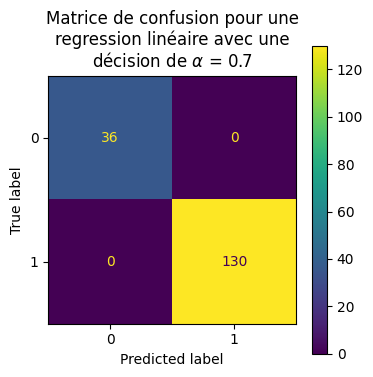

Le taux de bonne prédiction est  100.0 %.


In [157]:
# Dans un premier temps, commençons par observer les predictions sur les données d'entrainement :

# On transforme la régression en une classification en affectant la valeur 0 (False) aux valeurs <=0.5, et 1 (True) aux valeurs >0.5
y_pred_train = regr.predict(X_train)

bonne_pred = mon_score_perso(y_train, y_pred_train, alpha = 0.7, display_MC = True)

print("Le taux de bonne prédiction est ", round(bonne_pred*100,1),'%.')

Le taux de bonne prédiction (<u>sur les données d'entrainement</u>) est excellent (100 %) mais il s'agit de l'erreur d'entrainement !

Testons désormais notre modèle sur le jeu de validation :

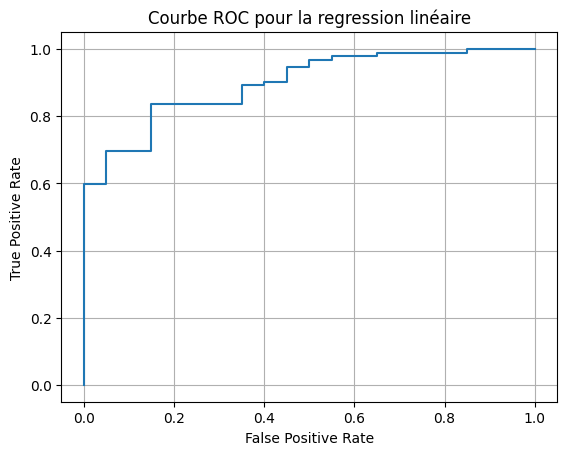

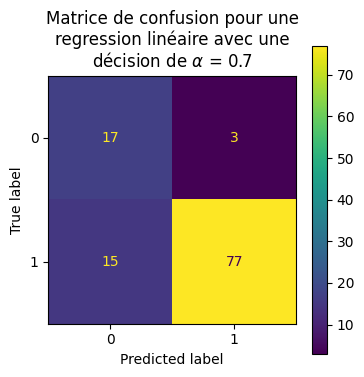

Le taux de bonne prédiction est  83.9 %.


In [158]:
# On teste maintenans la qualité de notre prédiction sur les données de validation

# On transforme la régression en une classification en affectant la valeur 0 (False) aux valeurs <=0.5, et 1 (True) aux valeurs >0.5
y_pred_valid = regr.predict(X_valid)

# Courbe ROC
roc_X_Y = roc_curve(y_valid, y_pred_valid)
plt.plot(roc_X_Y[0], roc_X_Y[1])
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Courbe ROC pour la regression linéaire')

# Calcul du score et affichage de la matrice de confusion
bonne_pred = mon_score_perso(y_valid, y_pred_valid, alpha = 0.7, display_MC = True)

print("Le taux de bonne prédiction est ", round(bonne_pred*100,1),'%.')

Etonnament le taux global de bonnes prédictions n'est pas si mauvais (autour de 80 %)

<i><u>Remarque 1 :</u> Evidemment, à chaque tirage, ce taux varie, mais semble tourner autour de 78-83 %</i>

<i><u>Remarque 2 :</u> en tenant compte des données cliniques (clinique = True), alors le taux atteint 86 % !</i>

### III - b) Regression linéaire sur composantes principales (PCR)

In [161]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [162]:
# On choisit une ACP avec 20 compsantes principales
pca = PCA(n_components=20)

# On applique l'ACP sur les données d'entrainement
pca.fit(X_train)
X_train_proj = pca.transform(X_train)

In [163]:
# On construit une regression linéaire à partir des données d'entrainement 
regr = LinearRegression()
regr.fit(X_train_proj, y_train)

LinearRegression()

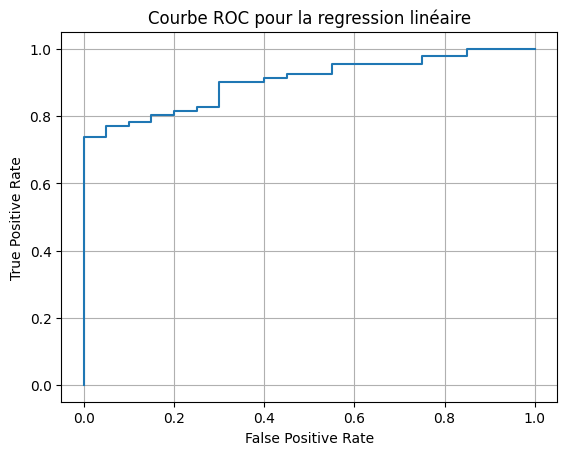

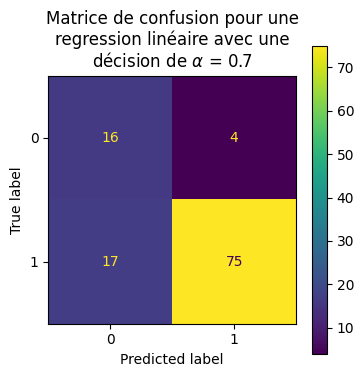

Le taux de bonne prédiction est  81.2 %.


In [165]:
# On teste la qualité de notre prédiction sur les données de validation

# On applique l'ACP
X_valid_proj = pca.transform(X_valid)

# On prédit y à partir des données projetées
y_pred_valid = regr.predict(X_valid_proj)


# Courbe ROC
roc_X_Y = roc_curve(y_valid, y_pred_valid)
plt.plot(roc_X_Y[0], roc_X_Y[1])
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Courbe ROC pour la regression linéaire')

# Calcul du score et affichage de la matrice de confusion
bonne_pred = mon_score_perso(y_valid, y_pred_valid, alpha = 0.7, display_MC = True)

print("Le taux de bonne prédiction est ", round(bonne_pred*100,1),'%.')



Le taux de bonne prédiction semble plus faible.

Essayons avec moins de composantes principales :

Taux de bonnes prédictions pour différents nb de composantes principales et différentes valeurs de alpha :

Pour 1 composante(s) principale(s) :
	alpha=0.6 : taux : 82.1 % //alpha=0.7 : taux : 82.1 % //alpha=0.8 : taux : 38.4 % //alpha=0.9 : taux : 18.8 % //alpha=1.0 : taux : 17.9 % //alpha=1.1 : taux : 17.9 % //
Pour 2 composante(s) principale(s) :
	alpha=0.6 : taux : 82.1 % //alpha=0.7 : taux : 82.1 % //alpha=0.8 : taux : 34.8 % //alpha=0.9 : taux : 18.8 % //alpha=1.0 : taux : 17.9 % //alpha=1.1 : taux : 17.9 % //
Pour 3 composante(s) principale(s) :
	alpha=0.6 : taux : 84.8 % //alpha=0.7 : taux : 76.8 % //alpha=0.8 : taux : 63.4 % //alpha=0.9 : taux : 30.4 % //alpha=1.0 : taux : 17.9 % //alpha=1.1 : taux : 17.9 % //
Pour 5 composante(s) principale(s) :
	alpha=0.6 : taux : 80.4 % //alpha=0.7 : taux : 81.2 % //alpha=0.8 : taux : 66.1 % //alpha=0.9 : taux : 33.9 % //alpha=1.0 : taux : 19.6 % //alpha=1.1 : taux : 17.9 % //
Pour 10 composante(s) principale(s) :
	alpha=0.6 : taux : 78.6 %

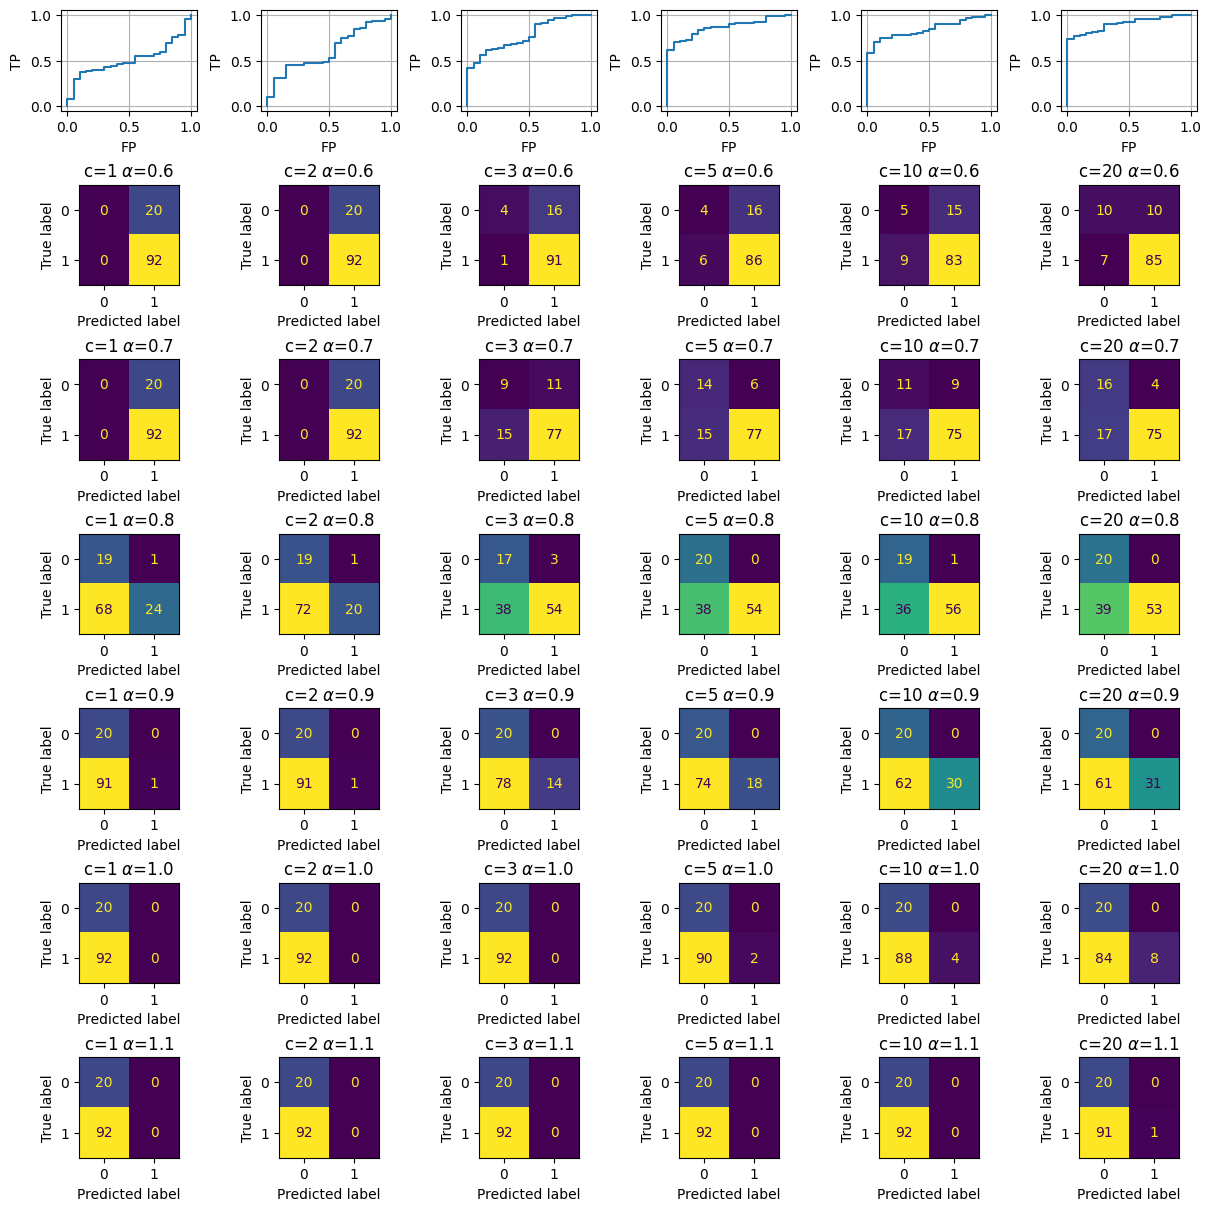

In [166]:
# On teste la qualité de notre prédiction sur les données de validation pour différents 
# nombres de composantes principales retenues

# Données en colonnes : nb de composantes
pas = 3
list_composantes = [1,2,3,5,10,20]  #list(range(1,20,pas))
n_col = len(list_composantes)

# Données en lignes : alpha
list_alpha = list(np.arange(0.6,1.1,0.1))
n_ligne = len(list_alpha)

# Figure
fig = plt.figure(figsize=(n_col*2, n_ligne*2), constrained_layout=True)
axs = fig.subplots(n_ligne+1, n_col)
print(f"Taux de bonnes prédictions pour différents nb de composantes principales et différentes valeurs de alpha :")

# Pour archivage des courbes ROC
Liste_courbes_ROC = []

for k, n_comp in enumerate(list_composantes):    
    print(f'\nPour {n_comp} composante(s) principale(s) :\n\t', end='')

    # Regression en ne conservant que n_comp composantes principales
    regr.fit(X_train_proj[:,0:n_comp], y_train)
    X_valid_proj = pca.transform(X_valid)
    y_pred_valid = regr.predict(X_valid_proj[:,0:n_comp])

    # Courbe ROC
    roc_X_Y = roc_curve(y_valid, y_pred_valid)
    Liste_courbes_ROC.append(roc_X_Y)
    axs[0, k].plot(roc_X_Y[0], roc_X_Y[1])
    axs[0, k].grid()
    axs[0, k].set_xlabel("FP")
    axs[0, k].set_ylabel("TP")


    for j, alpha in enumerate(list_alpha):
        print(f'alpha={round(alpha,2)} : ', end='')

        # Prediction binaire selon alpha
        y_pred_valid_alpha = 1*(y_pred_valid>alpha)

        # Matrice de confusion
        cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_valid_alpha)
        bonne_pred = (cm[0,0]+cm[1,1])/len(y_valid)
        print(f"taux :", round(bonne_pred*100,1),'% //', end='')
        cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[j+1, k], colorbar=False)

        axs[j+1, k].set_title(f'c={n_comp} '+r'$\alpha$'+f'={round(alpha,2)}')


<b><u>Ce qu'on observe : </u></b>
En ne conservant que 1 à 20 composantes principales, les taux de bonnes prédictions peuvent paraitres corrects dans certains cas (autour de 80%), mais l'analyse de la courbe ROC et des matrices de confusions révèle que certains modèles ne prédisent aucune réponse '0' ! 


Comparons les courbes ROC :

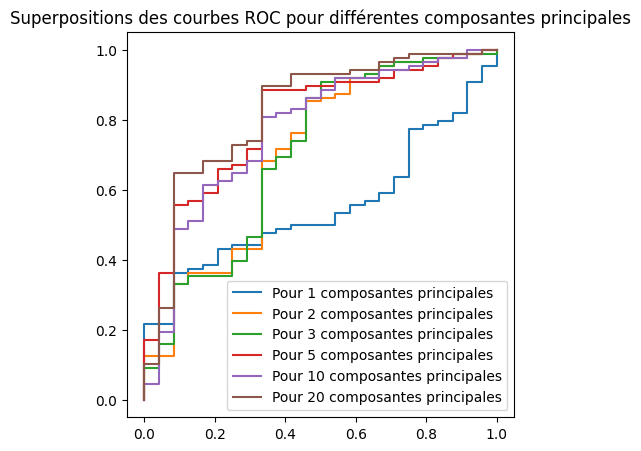

In [28]:
# Comparons les courbes ROC

# Figure
fig = plt.figure(figsize=(5,5))
ax = fig.subplots(1, 1)

for k, courbe in enumerate(Liste_courbes_ROC):
    ax.plot(courbe[0], courbe[1], label = f'Pour {list_composantes[k]} composantes principales')

plt.title('Superpositions des courbes ROC pour différentes composantes principales')
plt.legend()
plt.show()


La superposition des courbes ROC confirme que la conservation de 20 composantes principales semble plus intéressante (courbe plus « en haut à gauche », intégrale sur [0, 1] supérieure aux autres).

<b><u>Conclusion : </u></b>
La regression sur PCA n'est pas une méthode efficace ceci est dû sans aucun doute à la très grande dimension du jeu de données. En effet, la PCA n'est pas robuste à la grande dimension.

Finalement, il y a peu de modèles intéressants parmis tout ceux utilisant une PCA, testons d'autres méthodes réputées plus efficaces en cas de grande dimensions.

### III - C) Regression PLS (Partial Least Squares)

In [168]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


Commencons par effectuer une regression PLS en ne conservant que 5 composantes :

In [169]:
pls = PLSRegression(n_components=5)
pls.fit(X_train, y_train)


PLSRegression(n_components=5)

Evaluons le modele PLS sur les données d'entrainement avec alpha = 0.5 :

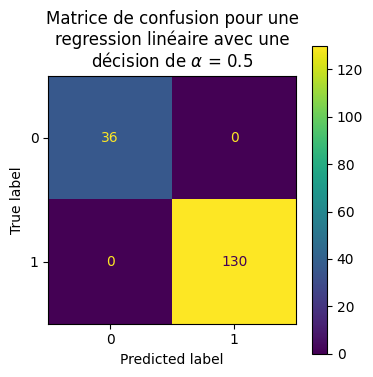

In [170]:
# évaluer le score d'entrainement
y_pred = pls.predict(X_train)

bonne_pred = mon_score_perso(y_train, y_pred_train, alpha = 0.5, display_MC = True)


100 % de bonnes prédictions ... sur les données d'entrainements !

Evaluons le score sur les données de validation avec le même alpha=0.5 :

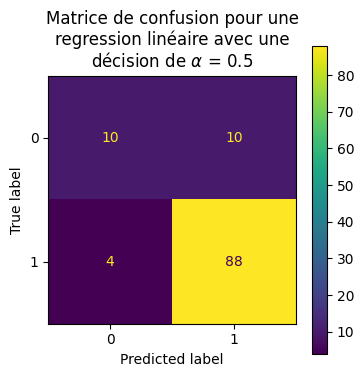

0.875


In [172]:
# évaluer le score de validation

y_pred = pls.predict(X_valid)

bonne_pred = mon_score_perso(y_valid, y_pred, alpha = 0.5, display_MC = True)
print(bonne_pred)

Le score est bien sûr plus faible, mais reste correct avec cette méthode (80 % de bonnes prévisions sur les données de validation).

<i><u>Remarque :</u> en tenant compte des données cliniques (clinique = True), la regression PLS est meilleure qu'avec une regression simple sur PCA, en effet, le taux atteint 89 % !</i>

<br>
Observons les courbes ROC pour différents nombres de composantes retenues afin de déterminer un alpha intéressant selon nos besoins :

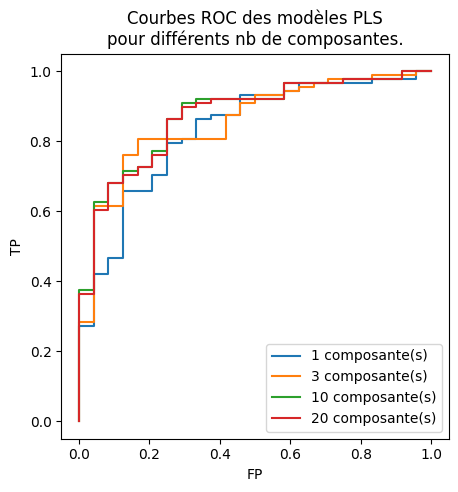

In [42]:

fig = plt.figure(figsize=(5,5))

ax = fig.subplots(1,1)
pas = 2

list_composantes2 = [1, 3, 10, 20]

for k in list_composantes2:

    # Modele PLS et ajustement
    pls = PLSRegression(n_components=k)
    pls.fit(X_train, y_train)

    # prediction    
    y_pred = pls.predict(X_valid)

    # Courbe ROC
    roc_X_Y = roc_curve(y_valid, y_pred)
    Liste_courbes_ROC.append(roc_X_Y)
    ax.plot(roc_X_Y[0], roc_X_Y[1], label=f'{k} composante(s)')
    ax.grid()
    ax.set_xlabel("FP")
    ax.set_ylabel("TP")
    ax.set_title('Courbes ROC des modèles PLS\npour différents nb de composantes.')

plt.legend()
plt.show()


A première vue, l'observation de ces différentes courbes ROC révèle que les méthodes ne conservant 10 ou 20 composantes semblent plus intéressantes, sans que la différence soit vraiment significative.

Une étude plus approfondie serait nécessaire pour davantage de précisions en gardant à l'esprit qu'un modèle avec moins de variables (moins de composantes) devra être privilégié.

### III - d) Regression LASSO

In [173]:
from sklearn import linear_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

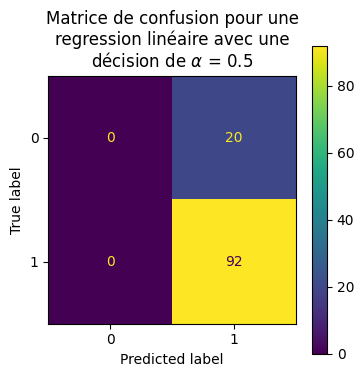

Le taux de bonne prédiction est  82.1 %.


In [174]:
# Création du modèle
clf = linear_model.Lasso(alpha=0.1)

# Ajustement sur les données d'entrainement
clf.fit(X_train, y_train)

# Prévision sur les données de valid
y_pred = clf.predict(X_valid)

# Calcul du score et Matrice de confusion
bonne_pred = mon_score_perso(y_valid, y_pred, alpha = 0.5, display_MC = True)

print("Le taux de bonne prédiction est ", round(bonne_pred*100,1),'%.')

Le taux obtenu est correct sans plus, mais aucune donnée n'a été prédite négative !

Testons avec différents paramètres.

<B>Pour cela nous allons utiliser GridSearch, <u>avec notre propre score.</u></b>


In [16]:
# La construction de cette fonction 'mon_score_GSCV' a été déplacé en partie II

In [177]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Utilisation de Grid_search avec notre propre score :

# Liste de paramètre alpha du Lasso à utiliser
ma_list = list(np.arange(0.01,0.1,0.01)) + list(np.arange(0.1,1,0.1)) + list(np.arange(1,10,1))

parameters = {'alpha':ma_list}
reg_lasso = Lasso()
clf = GridSearchCV(reg_lasso, parameters, scoring = mon_score_GSCV, verbose = 4)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END ........................alpha=0.01;, score=0.794 total time=   1.2s
[CV 2/5] END ........................alpha=0.01;, score=0.788 total time=   1.5s
[CV 3/5] END ........................alpha=0.01;, score=0.636 total time=   1.7s
[CV 4/5] END ........................alpha=0.01;, score=0.697 total time=   1.6s
[CV 5/5] END ........................alpha=0.01;, score=0.788 total time=   1.6s
[CV 1/5] END ........................alpha=0.02;, score=0.824 total time=   1.3s
[CV 2/5] END ........................alpha=0.02;, score=0.818 total time=   1.2s
[CV 3/5] END ........................alpha=0.02;, score=0.667 total time=   1.1s
[CV 4/5] END ........................alpha=0.02;, score=0.667 total time=   0.9s
[CV 5/5] END ........................alpha=0.02;, score=0.788 total time=   0.9s
[CV 1/5] END ........................alpha=0.03;, score=0.853 total time=   0.8s
[CV 2/5] END ........................alpha=0.03

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05,
                                   0.060000000000000005, 0.06999999999999999,
                                   0.08, 0.09, 0.1, 0.2, 0.30000000000000004,
                                   0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9,
                                   1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring=make_scorer(mon_score_perso), verbose=4)

In [178]:
# Quelques informations concernant les résultats  de GridSearchCV :
print(f"Listes de résultats possibles de Grid_Search : \n{list(clf.cv_results_.keys())}")
print(f"\nScore moyen pour chaque valeur de alpha testée : {clf.cv_results_['mean_test_score']}")
print(f"\nMeilleur score : {clf.best_score_}")
print(f"\nPour une valeur de alpha correspondante de : {clf.best_params_}")


Listes de résultats possibles de Grid_Search : 
['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score']

Score moyen pour chaque valeur de alpha testée : [0.74064171 0.75258467 0.75240642 0.75258467 0.77076649 0.77076649
 0.76470588 0.77664884 0.77664884 0.78253119 0.78253119 0.78253119
 0.78253119 0.78253119 0.78253119 0.78253119 0.78253119 0.78253119
 0.78253119 0.78253119 0.78253119 0.78253119 0.78253119 0.78253119
 0.78253119 0.78253119 0.78253119]

Meilleur score : 0.7825311942959002

Pour une valeur de alpha correspondante de : {'alpha': 0.1}


Le « alpha » cité est le paramètre du LASSO.

Appliquons la regression Lasso pour le meilleur estimateur trouvé et déterminons le score de validation :

In [179]:
regr_lasso_best = clf.best_estimator_
y_pred = regr_lasso_best.predict(X_valid)
ma_metrique(y_valid, y_pred)

0.8214285714285714

On trouve un score de valid de 77 %. C'est à dire que 77% des valeurs ont été bien prédites. Pour en savoir un peu plus, regardons la matrice de confusion :

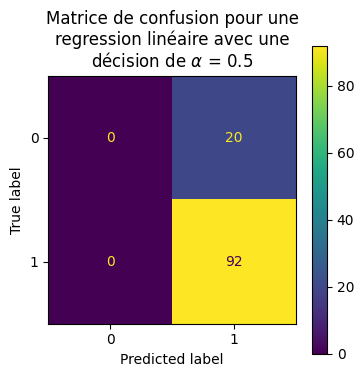

Le taux de bonne prédiction est  82.1 %.


In [180]:
# Calcul du score et Matrice de confusion
bonne_pred = mon_score_perso(y_valid, y_pred, alpha = 0.5, display_MC = True)

print("Le taux de bonne prédiction est ", round(bonne_pred*100,1),'%.')

Ce résultat est à nouveau décevant car le modèle n'a prédit presqu'aucune valeur négative !

Terminons l'étude de la méthode Lasso par ses courbes ROC :

C:\Users\kevin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.724e-03, tolerance: 2.521e-03
  model = cd_fast.enet_coordinate_descent(


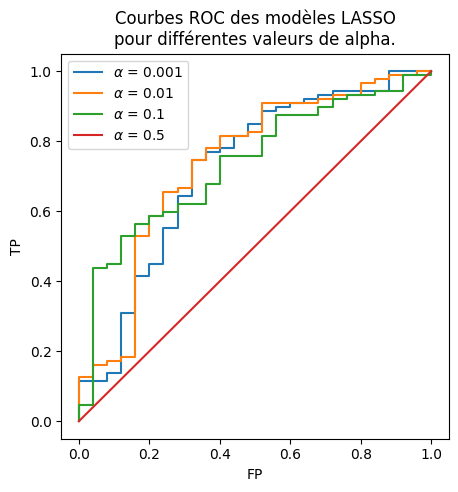

In [37]:

fig = plt.figure(figsize=(5,5))

ax = fig.subplots(1,1)

liste_alpha_LASS0 = [0.001, 0.01, 0.1, 0.5] #, 1, 10]

for alpha_LASSO in liste_alpha_LASS0:

    # Modele PLS et ajustement
    pls = Lasso(alpha = alpha_LASSO)
    pls.fit(X_train, y_train)

    # prediction    
    y_pred = pls.predict(X_valid)

    # Courbe ROC
    roc_X_Y = roc_curve(y_valid, y_pred)
    #Liste_courbes_ROC.append(roc_X_Y)
    ax.plot(roc_X_Y[0], roc_X_Y[1], label=r'$\alpha$'+f' = {alpha_LASSO}')
    ax.grid()
    ax.set_xlabel("FP")
    ax.set_ylabel("TP")
    ax.set_title('Courbes ROC des modèles LASSO\npour différentes valeurs de alpha.')

plt.legend()
plt.show()

### II - d) Automatisons la démarche pour tester d'autres regressions

Pour en savoir un peu plus sur les résultats suivant les différents régresseurs et différents paramètres, je vais créer une fonction qui va afficher les taux de bonnes prédictions et les matrices de confusion pour les différents paramètres ainsi que les courbes ROC :

In [414]:
def Explore_regressions(clf, params, erreur_valid = True, liste_alpha_seuil = [0.3, 0.4, 0.5, 0.6, 0.7], display_print = True, display_CM = True):
    """
    clf                          regresseur sklearn : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    params :            dict     dictionnaire contenant le paramètre (Pour l'instant un seul paramètre est géré)
    erreur_valid :      bool     if True : calcul de l'erreur de valid. if False calcul de l'erreur d'entrainement.
    liste_alpha_seuil : list     liste des seuil alpha à tester et afficher
    display_print :     bool     Affiche sur le std_out les résultats de score
    display_CM :        bool     Affiche toutes les matrices de confusion
    """

    if display_print: 
        print(f"Taux de bonnes prédictions pour différents paramètres et différentes valeurs de seuil alpha, ", end='')

    if erreur_valid:
        X = X_valid
        y = y_valid
        if display_print:
            print('test sur le jeu de validation :', end='')
    else:
        X = X_train
        y = y_train
        if display_print:
            print("test sur le jeu d'entrainement :", end='')

    # Données en lignes : le(s) paramètre(s) de clf
    liste_de_parametres = list(params.keys())
    key = liste_de_parametres[0]
    liste_du_parametre = params[key]
    n_ligne = len(liste_du_parametre)

    # Données en colonnes : paramètre alpha (seuil)
    n_col = len(liste_alpha_seuil) +1

    # 1ère figure
    if display_CM:
        fig = plt.figure(figsize=(n_col*2, n_ligne*2), constrained_layout=True)
        axs = fig.subplots(n_ligne, n_col)

    # Liste des courbes ROC pour affichage ultérieur
    liste_courbes_ROC = []

    # MATRICES DE CONFUSIONS
    for i, val_param in enumerate(liste_du_parametre):

        if display_CM:
            ax = axs[i,0]

        if display_print: 
            print(f'\n\t\nPour param = {val_param} :\n\t\t', end='')

        # une instance de clf avec le paramètre val_param
        regr = clf(alpha = val_param)

        # Regression
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X)

        # Une seule courbe ROC (une par ligne)
        roc_X_Y = roc_curve(y, y_pred)
        liste_courbes_ROC.append(roc_X_Y)
        if display_CM:
            ax.plot(roc_X_Y[0], roc_X_Y[1])
            ax.grid()
            ax.set_xlabel("FP")
            ax.set_ylabel("TP")
            ax.set_title(f'{clf.__name__[:5]}: param :{round(val_param,3)}')
                
        else:
            if display_CM:
                ax.set_title(f'Pas de courbe ROC pour un classifieur')
            pass

        for j, alpha in enumerate(liste_alpha_seuil):
            
            if display_print: 
                print(f' alpha={round(alpha,2)} : ', end='')

            # Prediction binaire selon alpha
            y_pred_alpha = 1*(y_pred>alpha)

            # Matrice de confusion
            cm = confusion_matrix(y_true=y_valid, y_pred=y_pred_alpha)
            bonne_pred = (cm[0,0]+cm[1,1])/len(y_valid)
            if display_print: 
                print(f"taux :", round(bonne_pred*100,1),'% //', end='')

            if display_CM:
                cm_display = ConfusionMatrixDisplay(cm).plot(ax=axs[i, j+1], colorbar=False)  
                if i==0:
                    axs[i, j+1].set_title(r'$\alpha$ ='+str(round(alpha,2)))
    plt.show()

    # Affichage des COURBES ROC sur le même graphique
    Liste_Aires = []
    fig = plt.figure(figsize=(8,8))
    for k, courbe in enumerate(liste_courbes_ROC):

        parametre = liste_du_parametre[k]

        # Calcul de l'aire sous la courbe :
        Aire = 0
        val_x = courbe[0][1::2]     # Attention : on prend une valeur sur 2 car les valeurs sont doublées (permettant un affichage en créneaux)
        val_y = courbe[1][1::2]
        for r in range(len(val_x)-1):
            Aire += val_y[r+1]*(val_x[r+1]-val_x[r])
        Liste_Aires.append((Aire, parametre)) # Archivage des résultats

        # Affichage de la courbe ROC
        plt.plot(courbe[0],courbe[1], label=f'Paramètre du {clf.__name__} : {round(parametre, 5)}\nAire sous la courbe ROC : {round(Aire,3)}')
        plt.title(f'Courbes ROC des modèles {clf.__name__} \npour différentes valeurs de paramètre.')
        plt.grid()
        plt.xlabel("FP")
        plt.ylabel("TP")
        plt.legend()

    # Meilleur paramètre selon l'aire sous la courbe
    max_aire = max(Liste_Aires)
    if display_print:
            print(f"Au vu de l'aire sous la courbe ROC, le meilleur paramètre est : {max_aire[1]}")

    # renvoie (L'aire Max, le meilleur paramètre, le regresseur)
    return((max_aire[0], max_aire[1], clf))


In [415]:
ma_list_lasso_param = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.3]
clf = Lasso
params = {'alpha':ma_list_lasso_param}
liste_alpha_seuil = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Taux de bonnes prédictions pour différents paramètres et différentes valeurs de seuil alpha, test sur le jeu de validation :
	
Pour param = 0.001 :
		 alpha=0.3 : taux : 79.5 % // alpha=0.4 : taux : 78.6 % // alpha=0.5 : taux : 77.7 % // alpha=0.6 : taux : 73.2 % // alpha=0.7 : taux : 66.1 % // alpha=0.8 : taux : 61.6 % // alpha=0.9 : taux : 50.0 % //
	
Pour param = 0.005 :
		 alpha=0.3 : taux : 78.6 % // alpha=0.4 : taux : 79.5 % // alpha=0.5 : taux : 75.9 % // alpha=0.6 : taux : 75.0 % // alpha=0.7 : taux : 67.0 % // alpha=0.8 : taux : 62.5 % // alpha=0.9 : taux : 49.1 % //
	
Pour param = 0.01 :
		 alpha=0.3 : taux : 79.5 % // alpha=0.4 : taux : 80.4 % // alpha=0.5 : taux : 76.8 % // alpha=0.6 : taux : 74.1 % // alpha=0.7 : taux : 70.5 % // alpha=0.8 : taux : 59.8 % // alpha=0.9 : taux : 48.2 % //
	
Pour param = 0.02 :
		 alpha=0.3 : taux : 79.5 % // alpha=0.4 : taux : 79.5 % // alpha=0.5 : taux : 77.7 % // alpha=0.6 : taux : 76.8 % // alpha=0.7 : taux : 75.0 % // alpha=0.8 : taux : 

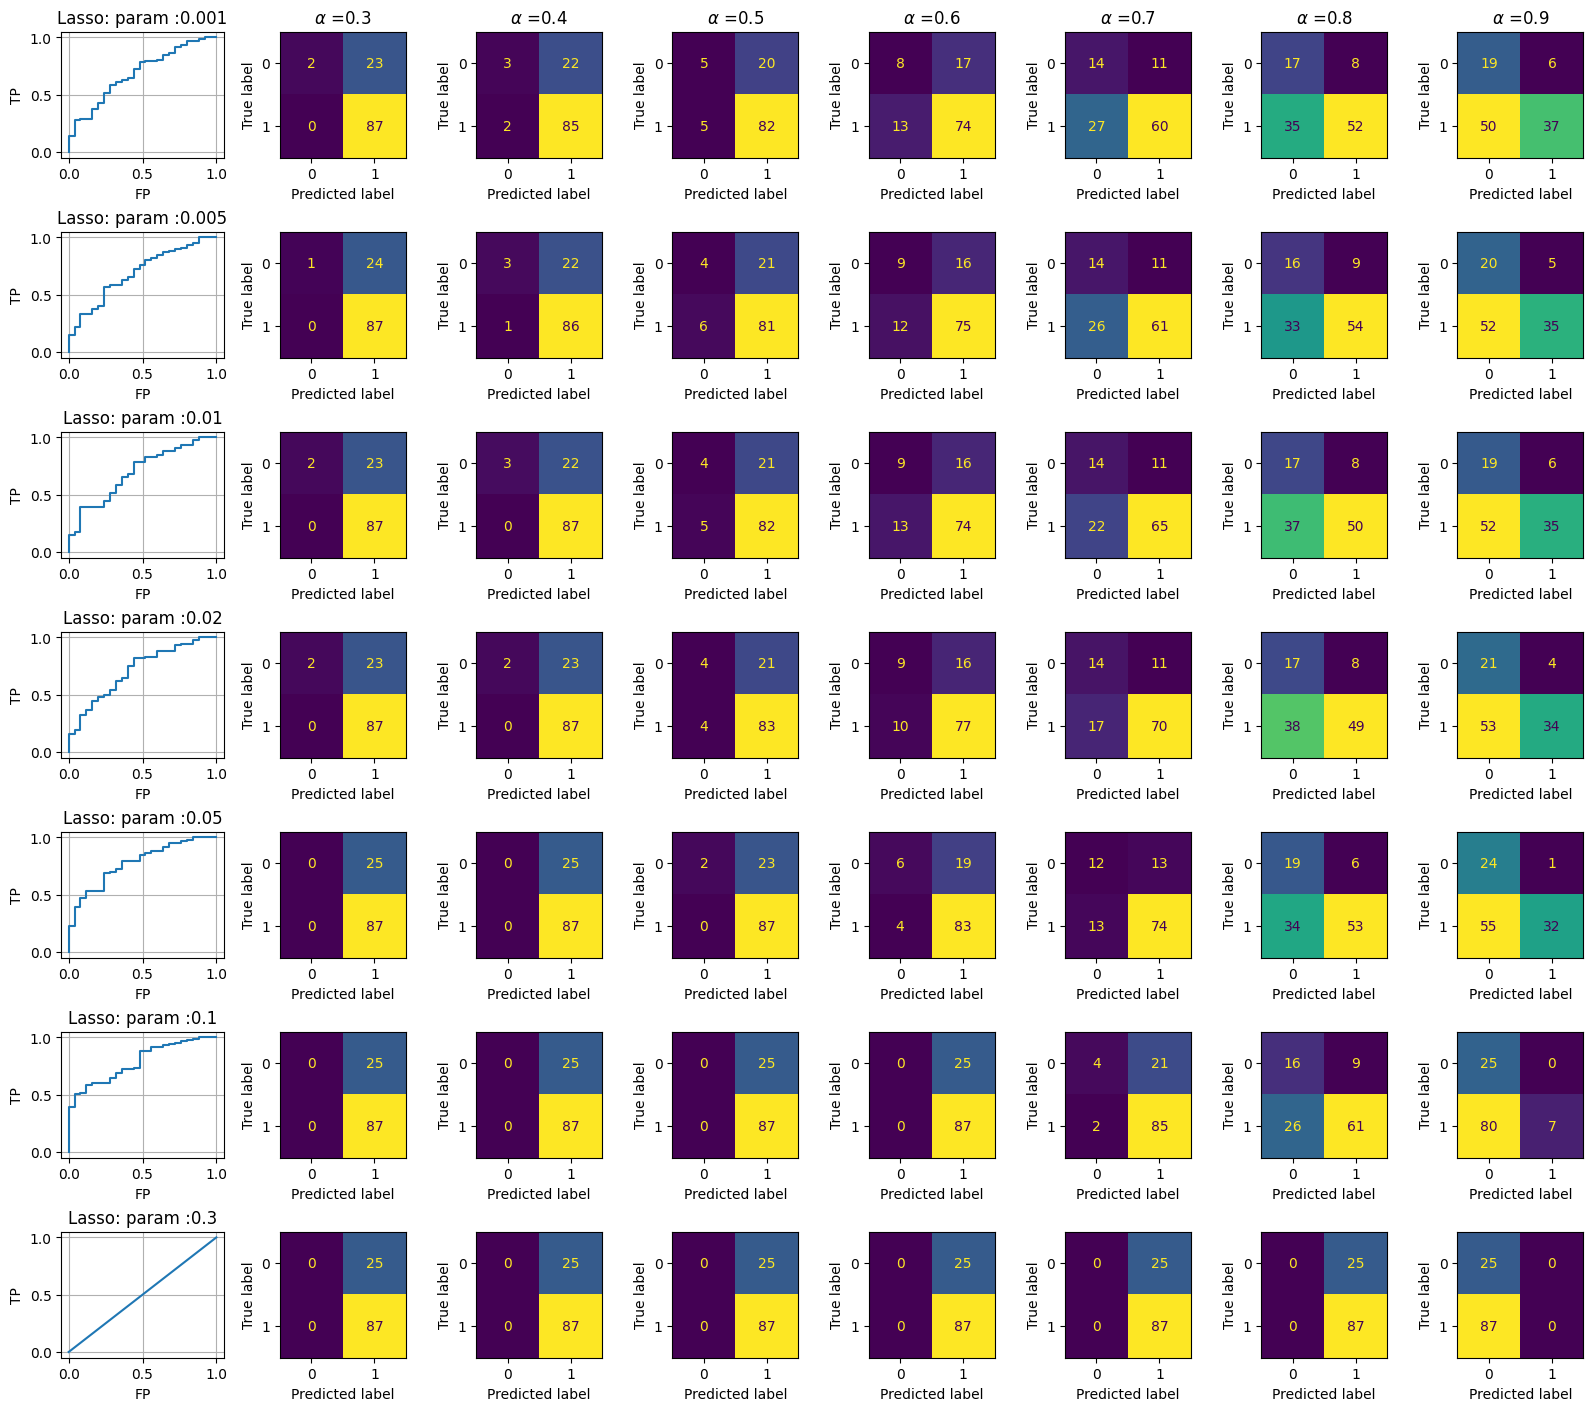

Au vu de l'aire sous la courbe ROC, le meilleur paramètre est : 0.1


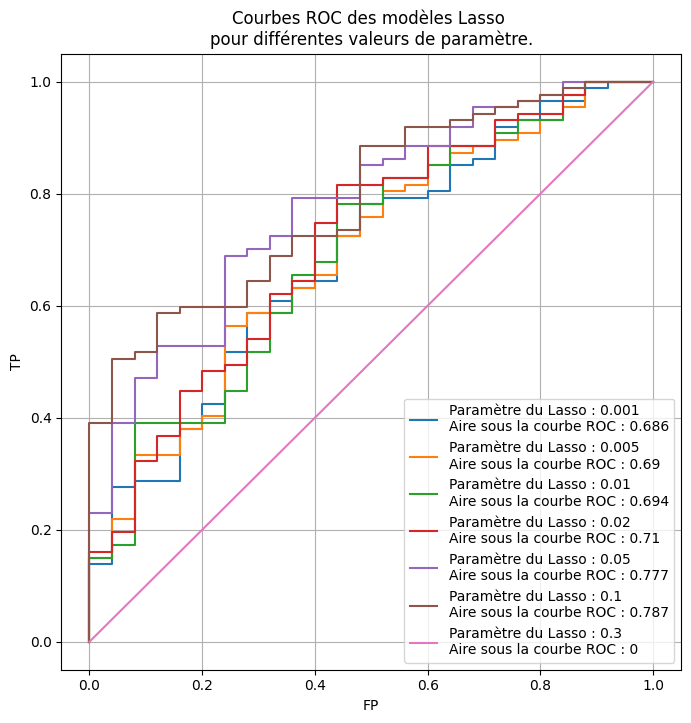

In [416]:
meilleur_parametre = Explore_regressions(    
                        clf, 
                        params, 
                        erreur_valid = True, 
                        liste_alpha_seuil = liste_alpha_seuil,
                        display_print = True,
                        )

En examinant les résultats et notamment l’aire sous la courbe ROC, le régresseur LASSO semble globalement plus intéressant pour le paramètre 0.1.

Mais la question de la sensibilité (taux de TP) et de la spécificité (taux de FP) nous invitera peut-être à choisir un autre paramètre.

<b>Conclusion :</b>

D’une façon générale, les courbes ROC ainsi que les matrices de confusion nous permettent de faire un choix éclairé sur la valeur des paramètres à choisir (paramètres des regresseur et du seuil α) selon nos besoins.


## III - f) ElasticNet, Ridge, …


Grâce à la fonctions précédente, je peux tester une multitude de régresseurs :




	Méthode : ElasticNet avec les paramètres : {'alpha': [0.01, 0.05, 0.1, 0.11, 0.15, 1]}

	Méthode : Ridge avec les paramètres : {'alpha': [0.01, 0.5, 2, 100, 1000, 10000]}


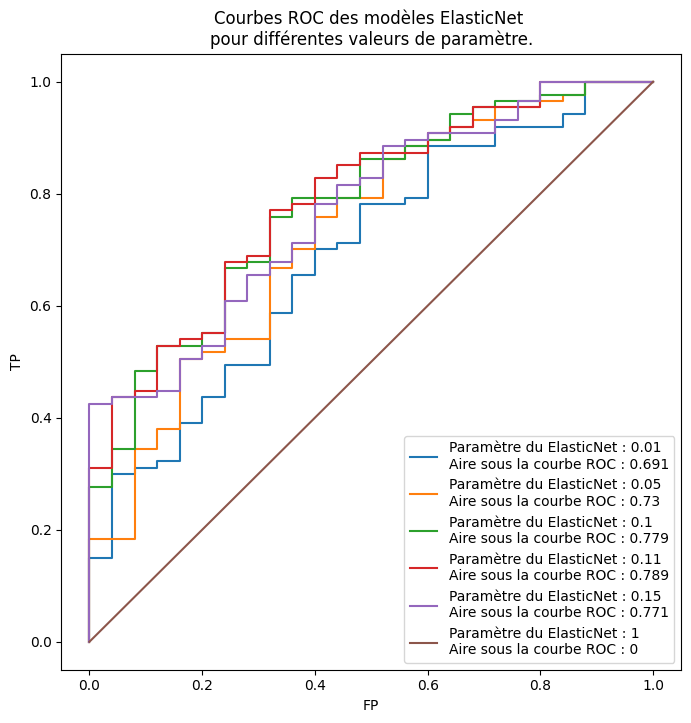

Selon la courbe ROC, le meilleur classifieur est Ridge, avec le paramètre 10000.


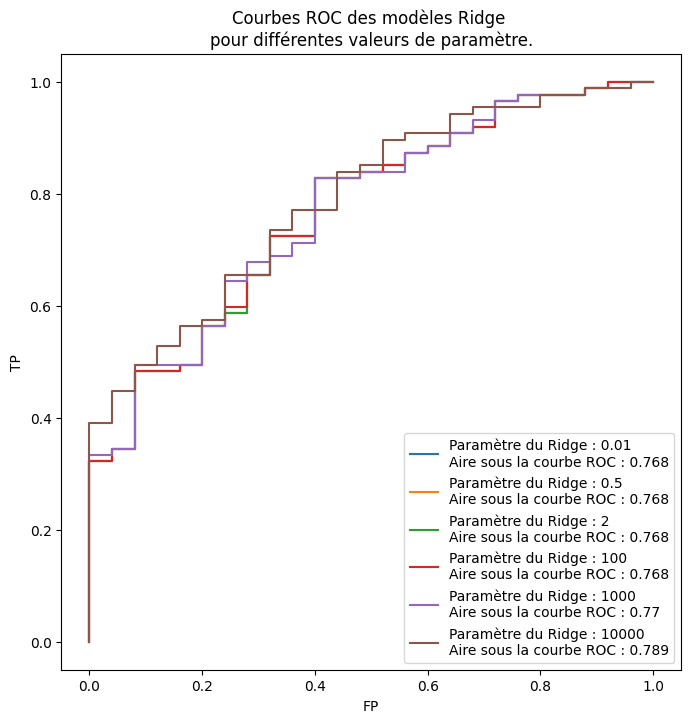

In [413]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

clfs = [ElasticNet, Ridge]
params_S = [ {'alpha':[0.01, 0.05, 0.1, 0.11, 0.15, 1]}, {'alpha':[0.01, 0.5, 2, 100, 1000, 10000]}]  #[0.0001, 0.01, 1]}]  
liste_alpha_seuil = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

liste_scores = []

for k, clf in enumerate(clfs):
    print(f"\n\tMéthode : {clf.__name__} avec les paramètres : {params_S[k]}")
    result = Explore_regressions(    
                        clf, 
                        params = params_S[k], 
                        erreur_valid = True, 
                        liste_alpha_seuil = liste_alpha_seuil,
                        display_print = False,
                        display_CM = False
                        )
    liste_scores.append(result)

meilleur = max(liste_scores)
print(f"Selon la courbe ROC, le meilleur classifieur est {meilleur[2].__name__}, avec le paramètre {meilleur[1]}.")


Remarque :  Bizarrement, des petites valeurs de pénalisation Ridge ne modifie pas la courbe ROC, ces résultats me paraissent aberrants.

### IV – Testons avec des méthodes de classification

Liste de regression ou classifications envisageables :

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Pour tester ces différents classifieurs, nous allons afficher les matrices de confusions pour différents paramètres. Pour cela, nous allons créer la fonction Explore_classifieurs() :

In [433]:
def Explore_classifieurs(clf, params, erreur_valid = True, display_print = True):
    """
    clf                      classifieur sklearn : https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    params :        dict     dictionnaire contenant le paramètre (Pour l'instant un seul paramètre est géré)
    erreur_valid :  bool     if True : calcul de l'erreur de valid. if False calcul de l'erreur d'entrainement.
    display_print : bool     Affiche sur le std_out les résultats de score
    """

    if erreur_valid:
        X = X_valid
        y = y_valid
        if display_print: 
            print('Erreur de validation :')
    else:
        X = X_train
        y = y_train
        if display_print: 
            print("Erreur d'entrainement :")

    liste_de_parametres = list(params.keys())
    liste_bonnes_pred = []

    for key in liste_de_parametres:

        # Définition de la fenêtre graphique
        from math import ceil       # partie entière supérieure
        n_param = len(params[key])
        n_col = ceil(np.sqrt(n_param))
        n_ligne = ceil(n_param / n_col)
        fig = plt.figure(figsize=(n_col*2, n_ligne*2), constrained_layout=True)
        axs = fig.subplots(n_ligne, n_col)
        fig.suptitle(f'Matrices de confusion pour la méthode {clf.__name__} et {n_param} paramètres')

        # liste des paramètres
        liste_du_parametre = params[key]

        for k, val in enumerate(liste_du_parametre):
            
            # Fenetre graphique
            ax = axs[k//n_col, k%n_col]
            ax.set_title(f"paramètre : {val}")

            mon_clf = clf() 
            
            exec(f"mon_clf.{key} = {val}")     # Affecter le paramètre 'key' au clf

            mon_clf.fit(X_train, y_train)
            y_pred = mon_clf.predict(X)

            # Matrice de confusion
            cm = confusion_matrix(y_true=y, y_pred=y_pred)
            cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax, colorbar=False)


            # Score (taux de bonnes prévisions)
            bonne_pred = (cm[0,0]+cm[1,1])/len(y)
            liste_bonnes_pred.append((bonne_pred, val))
            if display_print: 
                print(f"Le taux de bonne prédiction pour {key} = {round(val,2)} est ", round(bonne_pred*100,1),'%.')

        plt.show()

    return(max(liste_bonnes_pred))



Puis on exécute une boucle sur les classifieurs SVC, SGDCClassifier avec une liste de paramètres : 

In [430]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

clfs_classif = [SVC, SGDClassifier]
params_S = [ 
    {'C':[1, 1.5, 1.9, 2, 2.1, 2.2, 2.5, 10]}, 
    {'alpha':[0.0001, 0.001, 0.01, 0.1, 1, 1.2, 1.4, 1.6, 1.8, 1.9, 2, 2.1, 2.2, 2.4, 2.5, 2.6, 2.8, 10, 100, 1000]}
    ]

    

Méthode : SVC
Erreur de validation :
Le taux de bonne prédiction pour C = 1 est  77.7 %.
Le taux de bonne prédiction pour C = 1.5 est  77.7 %.
Le taux de bonne prédiction pour C = 1.9 est  78.6 %.
Le taux de bonne prédiction pour C = 2 est  79.5 %.
Le taux de bonne prédiction pour C = 2.1 est  78.6 %.
Le taux de bonne prédiction pour C = 2.2 est  78.6 %.
Le taux de bonne prédiction pour C = 2.5 est  79.5 %.
Le taux de bonne prédiction pour C = 10 est  79.5 %.


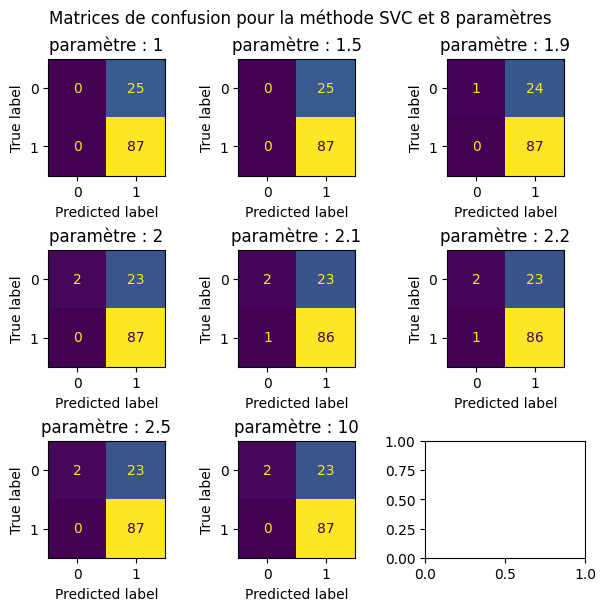

Selon le taux de bonne prédiction, le meilleur paramètre pour le classifieur SVC est 10.
Méthode : SGDClassifier
Erreur de validation :
Le taux de bonne prédiction pour alpha = 0.0 est  67.9 %.
Le taux de bonne prédiction pour alpha = 0.0 est  72.3 %.
Le taux de bonne prédiction pour alpha = 0.01 est  71.4 %.
Le taux de bonne prédiction pour alpha = 0.1 est  75.9 %.
Le taux de bonne prédiction pour alpha = 1 est  81.2 %.
Le taux de bonne prédiction pour alpha = 1.2 est  63.4 %.
Le taux de bonne prédiction pour alpha = 1.4 est  81.2 %.
Le taux de bonne prédiction pour alpha = 1.6 est  77.7 %.
Le taux de bonne prédiction pour alpha = 1.8 est  80.4 %.
Le taux de bonne prédiction pour alpha = 1.9 est  80.4 %.
Le taux de bonne prédiction pour alpha = 2 est  79.5 %.
Le taux de bonne prédiction pour alpha = 2.1 est  81.2 %.
Le taux de bonne prédiction pour alpha = 2.2 est  79.5 %.
Le taux de bonne prédiction pour alpha = 2.4 est  80.4 %.
Le taux de bonne prédiction pour alpha = 2.5 est  78.6 

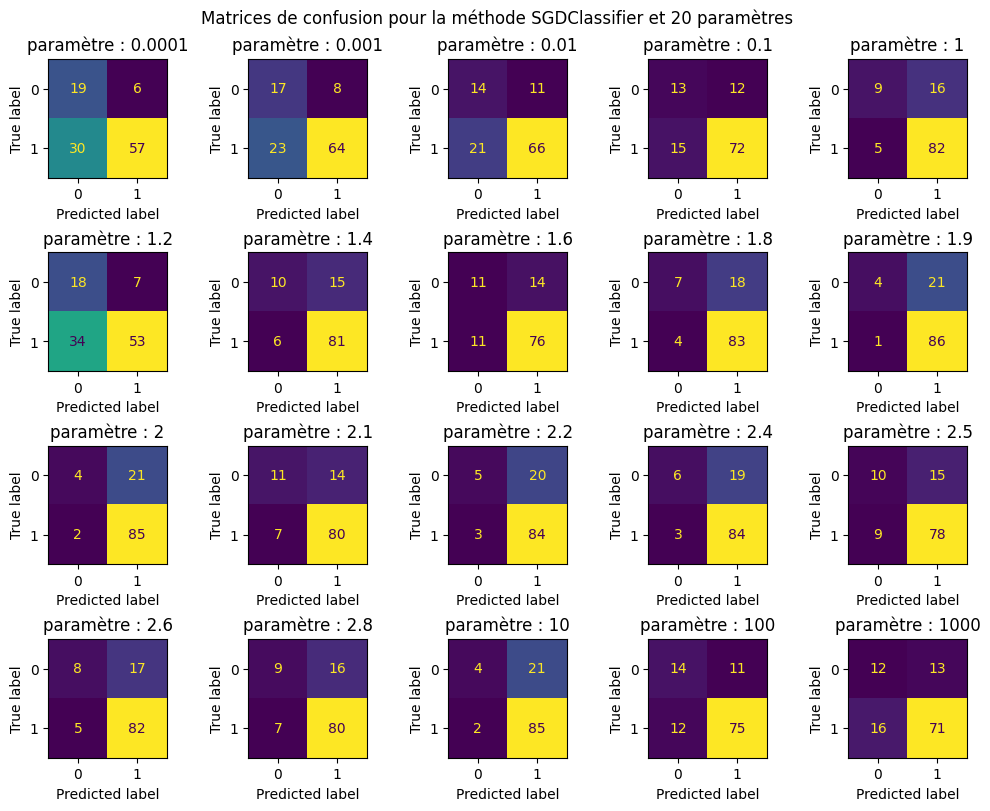

Selon le taux de bonne prédiction, le meilleur paramètre pour le classifieur SGDClassifier est 2.1.


In [434]:
for k, clf in enumerate(clfs_classif):
    print(f"Méthode : {clf.__name__}")

    result = Explore_classifieurs(    
                        clf, 
                        params = params_S[k], 
                        erreur_valid = True, 
                        display_print = True,
                        )
    
    print(f"Selon le taux de bonne prédiction, le meilleur paramètre pour le classifieur {clf.__name__} est {result[1]}.\n\n")


Parmi cette dernière méthode, il est intéressant de constater que, même si le taux global de bonne prédiction est parfois plus faible, il s'agit de la seule méthode qui nous donne bcp de Vrai Négatif en particulier pour alpha = 0.0001, 0.001, 1.4 et 100). Ce qui peut être intéressant dans certains contextes.

### V – Conclusion
 
En conclusion, nous avons exploré comment faire des prédictions de classe à partir d’un regresseur. Pour cela, nous avons utilisé le taux de « bonnes prédictions », mais également utilisé les courbes ROC et observé les matrices de confusion. On retiendra que nous pourrons choisir d’autres régresseurs ou classifieurs selon nos besoins (avoir une bonne sensibilité, ou une bonne spécificité, ou encore avoir un bon compromis).

Si nous devions ne garder qu’une seule méthode au vu de nos données, alors on utiliserait une PLS avec 10 composantes, ou un Lasso(0.1) avec seuil α=0,6 ou encore SGDCalssifier(2.1) pour leur bon score global (s’approchant des 85 %) mais aussi pour leur capacité à avoir un bon compromis sensibilité/spécificité.

Comme extension, pour une étude supplémentaire, nous pourrions également donner un poids supplémentaire aux classes sous représenté ou mal prédite, ce que nous n’avons pas fait ici.


In [ ]:
# TODO : reduction de dimension SPARSE